In [1]:
%matplotlib notebook

import os
import time
import numpy as np
import matplotlib as mpl

from collections import OrderedDict
from importlib import reload
from matplotlib import pyplot as plt

from labtools import mplplots; reload(mplplots)
from labtools.mplplots.init_nb_plotting import *
from labtools.mplplots import tools as mpltools

import qcodes as qc
from qcodes.dataset.measurements import Measurement
from qcodes.dataset.plotting import plot_by_id
from qcodes.dataset.data_set import DataSet, load_by_id
from qcodes.sweep import sweep, nest, chain, szip, getter, setter, time_trace
#from qcodes.sweep.sweep import ParameterSweep, Nest, ParameterWrapper, FunctionWrapper, FunctionSweep, getter
from pytopo.qctools import instruments as instools
import utils
from v2_dataset_tools.experiments import do_experiment, get_results_from_db_path
from qcodes.dataset.data_export import get_shaped_data_by_runid, get_data_by_id
from qcodes.dataset.data_set import load_by_id


from data_analysis.tools import curr2cond, smooth

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
m = 9.11e-31
h = 6.623e-34
h_bar = h/(2*np.pi)
e = 1.602e-19
E_F = 100e-3*e #J
m_eff = 0.023*m

v_F = np.sqrt(2*E_F/m_eff)

G0 = 2*e**2/h

In [3]:
from utils.utils import dic_data
from utils.utils.dic_data import dic2hdf5, data
import scipy.optimize as spy

## Load data file and list parameters

In [96]:
dat1 = load_by_id(743)
R_s = 23.4e3 # series R in Ohm
V_bias = 10e-3 #bias voltage in V
exc = 20e-6
dat1.get_parameters()

[mdac_gate_voltage (numeric),
 current (numeric),
 raw_voltage_dc (numeric),
 conductance (numeric),
 Lockin1_X (numeric),
 Lockin1_Y (numeric),
 Lockin1_R (numeric),
 Lockin1_phase (numeric),
 Lockin1_excitation (numeric)]

## Basic plotting: no R_S subtraction

<IPython.core.display.Javascript object>


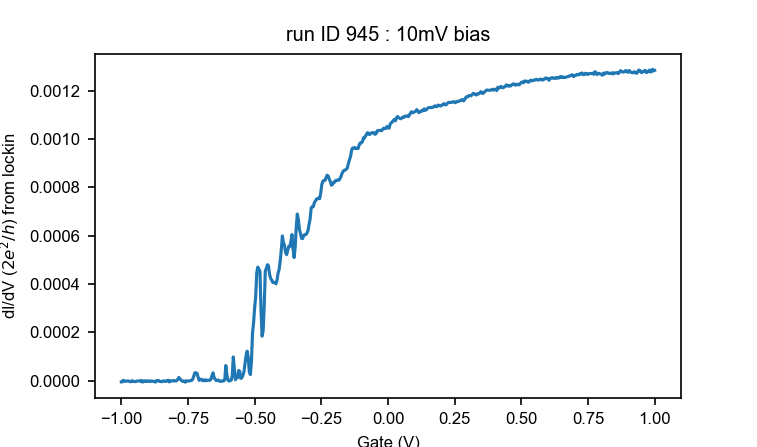

Text(0,0.5,'dI/dV ($2e^2/h$) from lockin')

In [379]:
dat1 = load_by_id(945)
gate_values = np.array(dat1.get_values('mdac_gate_voltage'))
current_values = np.array(dat1.get_values('Lockin1_X'))
plt.figure()
plt.plot(gate_values, current_values)
plt.title('run ID ' + '{}'.format(dat1.run_id)+' : 10mV bias')
plt.xlabel('Gate (V)')
plt.ylabel('dI/dV ($2e^2/h$) from lockin')

<IPython.core.display.Javascript object>


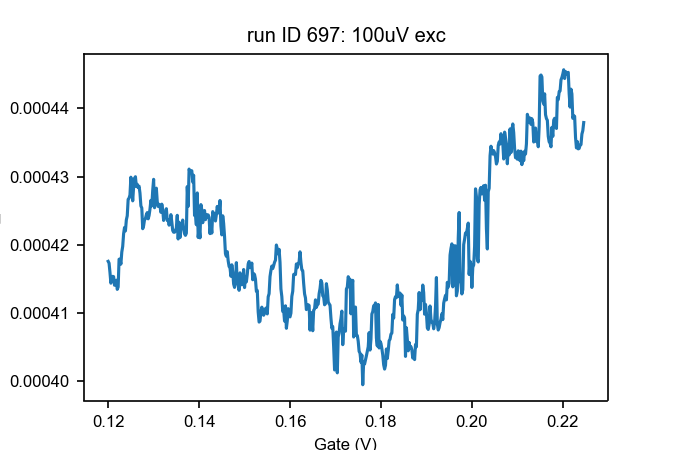

Text(0,0.5,'Lockin1_X (V)')

In [13]:
gate_values = np.array(dat1.get_values('AMI430_x_field'))[600:,0]
current_values = np.array(dat1.get_values('Lockin1_X'))[600:,0]
plt.figure()
plt.plot(gate_values, current_values)
plt.title('run ID ' + '{}'.format(dat1.run_id) + ': 100uV exc')
plt.xlabel('Gate (V)')
plt.ylabel('Lockin1_X (V)')

## With $R_s$ subtraction - lock in

<IPython.core.display.Javascript object>


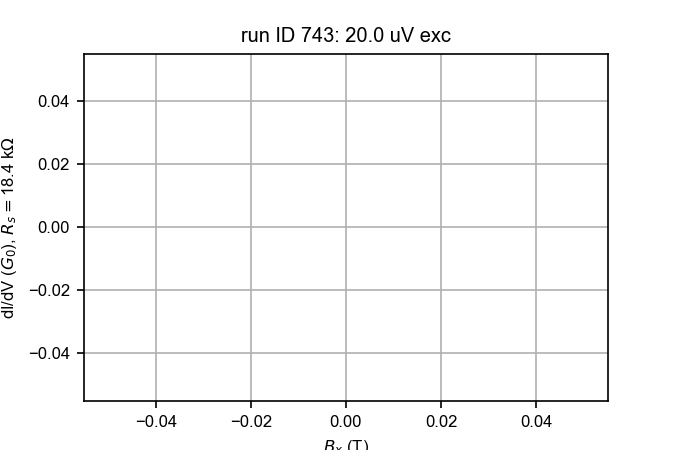

In [95]:
gate_values = np.array(dat1.get_values('AMI430_x_field'))[2600:3000,0]
conductance_values = np.array(dat1.get_values('Lockin1_X'))[2600:3000,0]
res = (exc/(conductance_values/1e6) - R_s)/12906
plt.figure()
plt.plot(gate_values, 1/res)
plt.title('run ID ' + '{}'.format(dat1.run_id) + ': ' + str(exc*1e6) + ' uV exc')
plt.xlabel('$B_x$ (T)')
plt.ylabel('dI/dV ($G_0$), $R_s=$' + str(R_s/1e3) + ' k$\Omega$')
plt.grid(b=True)
#plt.ylim(-0.5,5)

<IPython.core.display.Javascript object>


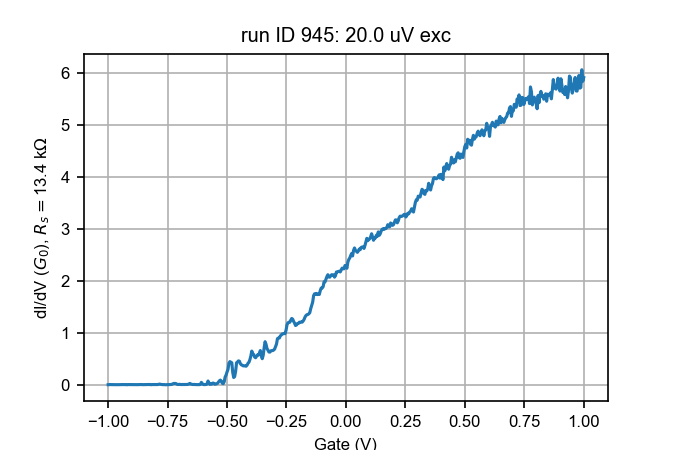

In [380]:
dat1 = load_by_id(945)
R_s = 13.4e3 # series R in Ohm
exc = 20e-6

gate_values = np.array(dat1.get_values('mdac_gate_voltage'))[:,0]
conductance_values = np.array(dat1.get_values('Lockin1_X'))[:,0]
res = (exc/(conductance_values/1e6) - R_s)/12906
plt.figure()
plt.plot(gate_values, 1/res)
plt.title('run ID ' + '{}'.format(dat1.run_id) + ': ' + str(exc*1e6) + ' uV exc')
plt.xlabel('Gate (V)')
plt.ylabel('dI/dV ($G_0$), $R_s=$' + str(R_s/1e3) + ' k$\Omega$')
plt.grid(b=True)

## With $R_s$ subtraction - DC

<IPython.core.display.Javascript object>


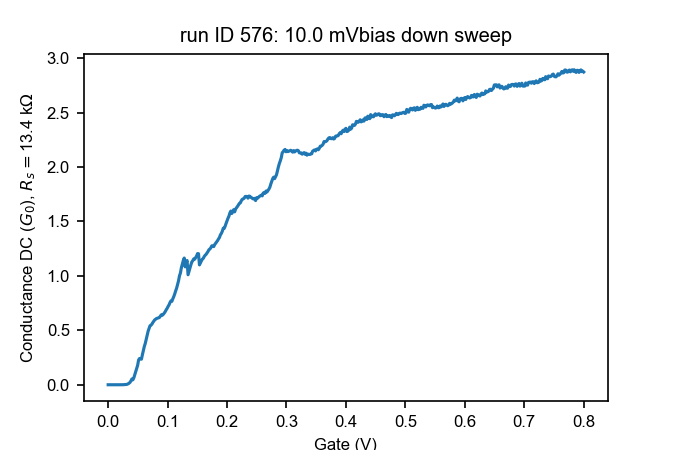

Text(0,0.5,'Conductance DC ($G_0$), $R_s=$13.4 k$\\Omega$')

In [44]:
gate_values = np.array(dat1.get_values('mdac_gate_voltage'))[:,0]
current_values = np.array(dat1.get_values('current'))[:,0]
res = (V_bias/current_values - R_s)/12906
plt.figure()
plt.plot(gate_values, 1/res)
plt.title('run ID ' + '{}'.format(dat1.run_id) + ': ' + str(V_bias*1e3) + ' mVbias down sweep')
plt.xlabel('Gate (V)')
plt.ylabel('Conductance DC ($G_0$), $R_s=$' + str(R_s/1e3) + ' k$\Omega$')
#plt.ylim(-0.5,6)

## Up and down sweeps in one run

In [12]:
dat1.run_id

680

<IPython.core.display.Javascript object>


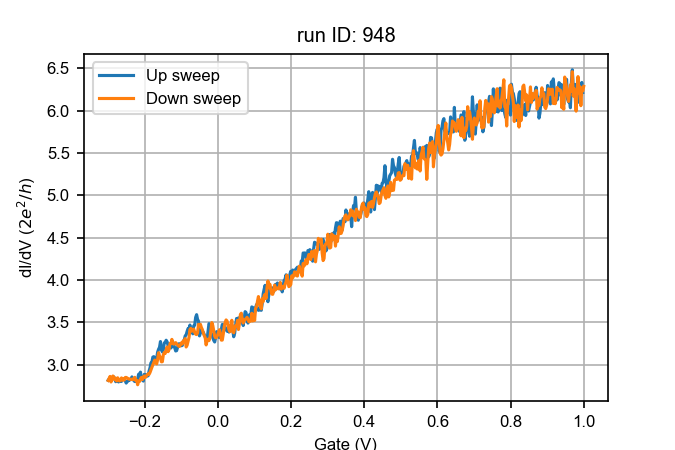

In [426]:
# lockin
dat1 = load_by_id(948)
gate_values = np.array(dat1.get_values('mdac_gate_voltage'))
current_values = np.array(dat1.get_values('conductance'))
npoints = int(gate_values.size/2)
gate_down = gate_values[0:npoints]
current_down = current_values[0:npoints]
gate_up = gate_values[npoints:-1]
current_up = current_values[npoints:-1]
plt.figure('testwater')
plt.title('run ID: {}'.format(dat1.run_id))
plt.plot(gate_up, current_up, label='Up sweep')
plt.plot(gate_down, current_down, label='Down sweep')
# plt.plot(gate_values, current_values, label='Sweep')
plt.xlabel('Gate (V)')
plt.ylabel(r'dI/dV ($2e^2/h$)')
# plt.ylabel('Current (A)')
plt.legend()
plt.grid(b=True)

<IPython.core.display.Javascript object>


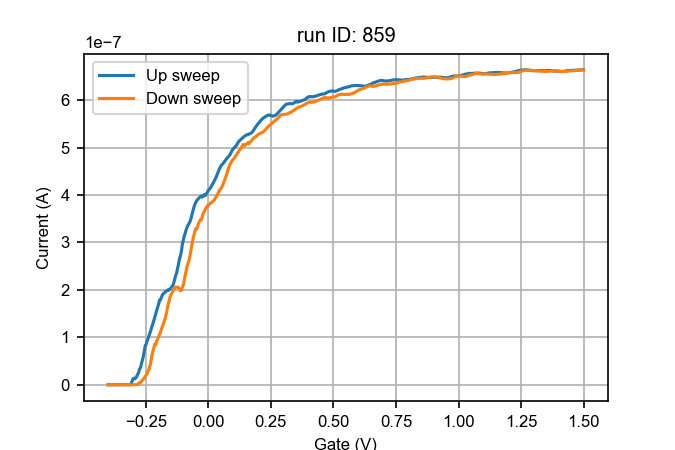

In [252]:
# current
dat1 = load_by_id(859)
gate_values = np.array(dat1.get_values('mdac_gate_voltage'))
current_values = np.array(dat1.get_values('current'))
npoints = int(gate_values.size/2)
gate_down = gate_values[0:npoints]
current_down = current_values[0:npoints]
gate_up = gate_values[npoints:-1]
current_up = current_values[npoints:-1]
plt.figure('current up down')
plt.title('run ID: {}'.format(dat1.run_id))
plt.plot(gate_up, current_up, label='Up sweep')
plt.plot(gate_down, current_down, label='Down sweep')
# plt.plot(gate_values, current_values, label='Sweep')
plt.xlabel('Gate (V)')
plt.ylabel('Current (A)')
plt.legend()
plt.grid(b=True)

## Up and down in two runs

In [29]:
dat1 = load_by_id(602)
dat2 = load_by_id(603)
R_s = 13.4e3 # series R in Ohm
V_bias = 10e-3 #bias voltage in V
dat1.get_parameters()

[mdac_gate_voltage (numeric),
 current (numeric),
 raw_voltage_dc (numeric),
 conductance (numeric),
 Lockin1_X (numeric),
 Lockin1_Y (numeric),
 Lockin1_R (numeric),
 Lockin1_phase (numeric),
 Lockin1_excitation (numeric)]

<IPython.core.display.Javascript object>


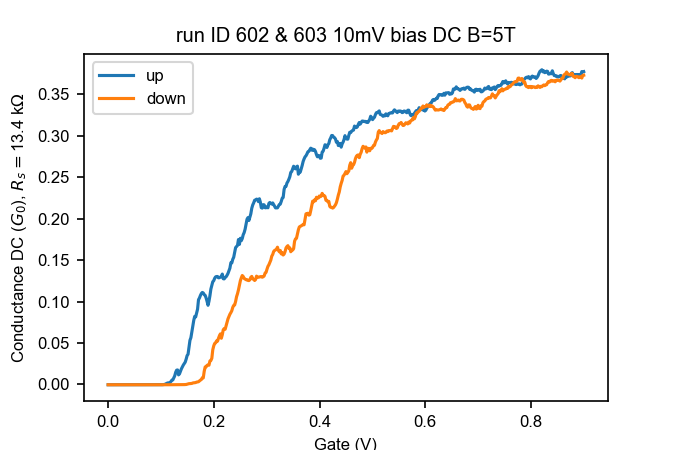

In [30]:
gate_up = np.array(dat1.get_values('mdac_gate_voltage'))[:,0]
current_up = np.array(dat1.get_values('current'))[:,0]
gate_down = np.array(dat2.get_values('mdac_gate_voltage'))[:,0]
current_down = np.array(dat2.get_values('current'))[:,0]

conductance_dc_up = 12906/(V_bias/current_up - R_s)
conductance_dc_down = 12906/(V_bias/current_down - R_s)

plt.figure('10mV hysteresis')
plt.plot(gate_up, conductance_dc_up, gate_down, conductance_dc_down)
plt.title('run ID ' + '{}'.format(dat1.run_id) + ' & ' + '{}'.format(dat2.run_id) + ' 10mV bias DC B=5T')
plt.xlabel('Gate (V)')
plt.ylabel('Conductance DC ($G_0$), $R_s=$' + str(R_s/1e3) + ' k$\Omega$')
plt.legend(['up', 'down'])

### gate leakage

<IPython.core.display.Javascript object>


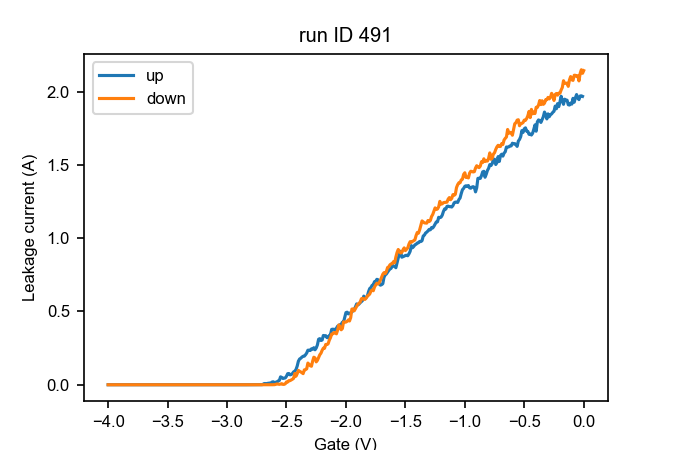

In [577]:
#conductance_up = current_up/(V_bias - current_up*R_s)
#conductance_down = current_down/(V_bias - current_down*R_s)

plt.figure('Leakage current')
plt.plot(gate_up, current_up, gate_down, current_down)
plt.title('run ID ' + '{}'.format(dat1.run_id))
plt.xlabel('Gate (V)')
plt.ylabel('Leakage current (A)')
plt.legend(['up', 'down'])

In [580]:
np.append(np.linspace(4, 0, 8), np.linspace(0, 4, 8))

array([4.        , 3.42857143, 2.85714286, 2.28571429, 1.71428571,
       1.14285714, 0.57142857, 0.        , 0.        , 0.57142857,
       1.14285714, 1.71428571, 2.28571429, 2.85714286, 3.42857143,
       4.        ])

## Pinchoff with $R_\text{series}$ correction

To do: add mobility fitting

<IPython.core.display.Javascript object>


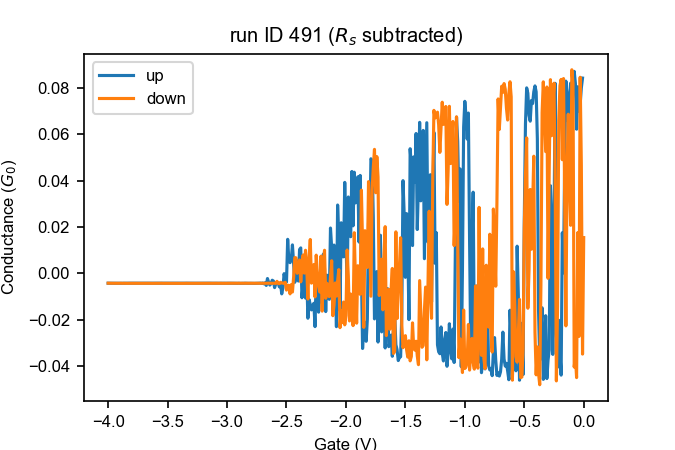

In [575]:
conductance_up = current_up/(V_bias - current_up*R_s)
conductance_down = current_down/(V_bias - current_down*R_s)
plt.figure('conductance minus R_s')
plt.plot(gate_up, conductance_up*12906, gate_down, conductance_down*12906)
plt.title('run ID ' + '{}'.format(dat1.run_id) + ' ($R_s$ subtracted)')
plt.xlabel('Gate (V)')
plt.ylabel('Conductance ($G_0$)')
plt.legend(['up', 'down'])

## 2D plots

In [517]:
from qcodes.dataset.experiment_container import Experiment
dat2D = load_by_id(949)
exp = Experiment(dat2D.path_to_db)
exp.exp_id = dat2D.exp_id
dat2D.exp_name = exp.name

R_s = 25.4e3 # series R in Ohm
dat2D.get_parameters()

[mdac_gate_voltage (numeric),
 lockin_dc (numeric),
 current (numeric),
 raw_voltage_dc (numeric),
 conductance (numeric),
 Lockin1_X (numeric),
 Lockin1_Y (numeric),
 Lockin1_R (numeric),
 Lockin1_phase (numeric),
 Lockin1_excitation (numeric)]

In [429]:
inner_loop_values = np.unique(dat2D.get_values('lockin_dc'))
outer_loop_values = np.unique(dat2D.get_values('mdac_gate_voltage'))
lockin_X = np.array(dat2D.get_values('conductance'))[:,0].reshape((inner_loop_values.size, outer_loop_values.size))
lockin_X.shape


ValueError: cannot reshape array of size 6832 into shape (201,34)

In [118]:
def colorplot(data, fast_s, slow_s, z, AC='True'):
    fig=plt.figure()
    plt.title('run ID ' + '{}, '.format(data.run_id) + str(dat2D.exp_name)+ ' : 20uV exc')
    #data = data[0]
    fs = np.unique(data.get_values(fast_s))
    ss = np.unique(data.get_values(slow_s))
    #print((data.get_values(slow_s)))
    data_z = np.array(data.get_values(z))  
    r_line = 18.4e3
    conductance = 12906/(2e-5/(data_z/1e6) - r_line)
    print(min(conductance), max(conductance))
    cmap = plt.cm.seismic #seismic, viridis, magma
    norm = mpl.colors.Normalize(vmin=-0, vmax=3)
    sm = plt.cm.ScalarMappable(cmap=cmap,norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm)
    cbar.ax.set_ylabel('dI/dV ($G_0$)')
    plt.pcolor(np.unique(fs)[::-1]*1e3, np.unique(ss)[::-1], np.reshape(conductance,(len(np.unique(ss)),len(np.unique(fs)))), cmap=cmap, norm=norm)
    #plt.xlabel(fast_s + ' (V)')
    #plt.ylabel(slow_s + ' (V)')
    plt.xlabel('Bias (mV)')
    plt.ylabel('Gate (V)')
    plt.tight_layout()
    #plt.savefig(r'D:\Data\images\20180711_' + str(dat2D.exp_name) +'.png')
    #plt.xlim(-0.011,0.011)
    #plt.ylim(0.1,0.3)

<IPython.core.display.Javascript object>


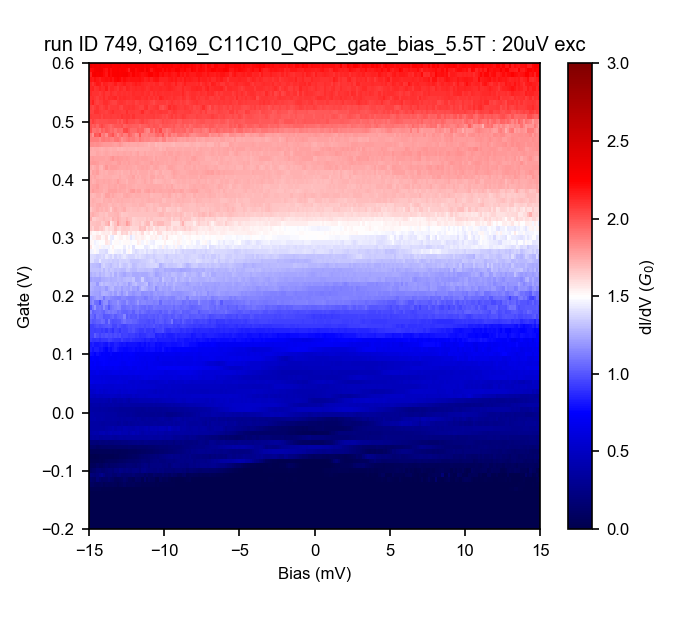

[-0.06762411] [2.34792237]


In [119]:
colorplot(dat2D, 'lockin_dc', 'mdac_gate_voltage', 'Lockin1_X')

### 1D from 2D plot

In [290]:
def plot1D_from_2D(data, x, y, x2, index):
    b = np.unique(np.array(data.get_values(x))) #[::-1]
    print(b)
    npoints = len(b)
    v2 = np.array(data.get_values(x2))
    x2_value = v2[index*npoints]
    points = v2 == v2[index*npoints]#x2_value #np.abs((v2 - x2_value)/x2_value) < 1e-6 #v2 == x2_value   # np.abs((v2 - x2_value)/x2_value) < 1e-6
    
    #plt.plot(points)
    g = np.array(data.get_values(y))
    g = g[points]
    #g = smooth(g, 21, 3)
    #g_sub = curr2cond(g, 20e-6, 15e3)
    #print(b, g)
    print(x2_value)
    plt.plot(b, g[::-1], label=x2+' = '+str(x2_value)[1:4]+' T')
    plt.xlabel(x+' (V)')
    plt.ylabel('dI/dV (G0)')
    plt.legend()
    plt.tight_layout()
    plt.savefig(r'D:\Data\images\20180711_' + str(dat2D.exp_name) + '_%.3fT.png'%(x2_value))
    
    #return b #, g_sub

<IPython.core.display.Javascript object>


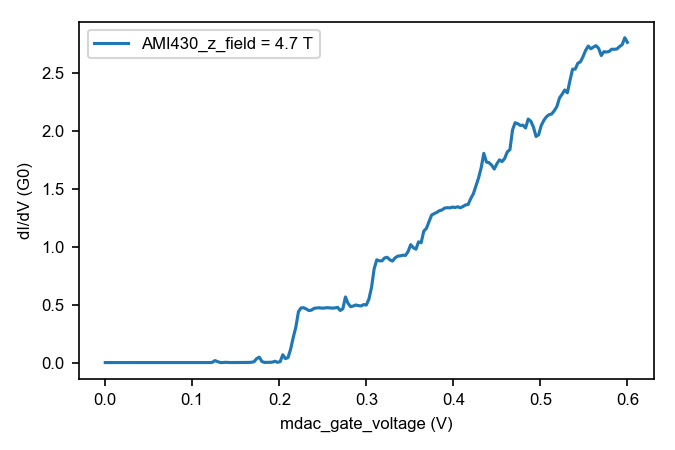

[0.    0.003 0.006 0.009 0.012 0.015 0.018 0.021 0.024 0.027 0.03  0.033
 0.036 0.039 0.042 0.045 0.048 0.051 0.054 0.057 0.06  0.063 0.066 0.069
 0.072 0.075 0.078 0.081 0.084 0.087 0.09  0.093 0.096 0.099 0.102 0.105
 0.108 0.111 0.114 0.117 0.12  0.123 0.126 0.129 0.132 0.135 0.138 0.141
 0.144 0.147 0.15  0.153 0.156 0.159 0.162 0.165 0.168 0.171 0.174 0.177
 0.18  0.183 0.186 0.189 0.192 0.195 0.198 0.201 0.204 0.207 0.21  0.213
 0.216 0.219 0.222 0.225 0.228 0.231 0.234 0.237 0.24  0.243 0.246 0.249
 0.252 0.255 0.258 0.261 0.264 0.267 0.27  0.273 0.276 0.279 0.282 0.285
 0.288 0.291 0.294 0.297 0.3   0.303 0.306 0.309 0.312 0.315 0.318 0.321
 0.324 0.327 0.33  0.333 0.336 0.339 0.342 0.345 0.348 0.351 0.354 0.357
 0.36  0.363 0.366 0.369 0.372 0.375 0.378 0.381 0.384 0.387 0.39  0.393
 0.396 0.399 0.402 0.405 0.408 0.411 0.414 0.417 0.42  0.423 0.426 0.429
 0.432 0.435 0.438 0.441 0.444 0.447 0.45  0.453 0.456 0.459 0.462 0.465
 0.468 0.471 0.474 0.477 0.48  0.483 0.486 0.489 0.

In [307]:
plt.figure()

#dat2D.get_parameters()#values('conductance')
plot1D_from_2D(dat2D, 'mdac_gate_voltage', 'conductance', 'AMI430_z_field', 7)
dat2D.run_id = 615


In [35]:
10e-3/5e-7

20000.0

In [17]:
plot1D_from_2D(dat1, 'gate_voltage', 'dI', 'bias_voltage', 0.003)

### View gate or bias setpoints

In [123]:
np.unique(dat2D.get_values('lockin_dc'))

array([-0.015  , -0.01485, -0.0147 , -0.01455, -0.0144 , -0.01425,
       -0.0141 , -0.01395, -0.0138 , -0.01365, -0.0135 , -0.01335,
       -0.0132 , -0.01305, -0.0129 , -0.01275, -0.0126 , -0.01245,
       -0.0123 , -0.01215, -0.012  , -0.01185, -0.0117 , -0.01155,
       -0.0114 , -0.01125, -0.0111 , -0.01095, -0.0108 , -0.01065,
       -0.0105 , -0.01035, -0.0102 , -0.01005, -0.0099 , -0.00975,
       -0.0096 , -0.00945, -0.0093 , -0.00915, -0.009  , -0.00885,
       -0.0087 , -0.00855, -0.0084 , -0.00825, -0.0081 , -0.00795,
       -0.0078 , -0.00765, -0.0075 , -0.00735, -0.0072 , -0.00705,
       -0.0069 , -0.00675, -0.0066 , -0.00645, -0.0063 , -0.00615,
       -0.006  , -0.00585, -0.0057 , -0.00555, -0.0054 , -0.00525,
       -0.0051 , -0.00495, -0.0048 , -0.00465, -0.0045 , -0.00435,
       -0.0042 , -0.00405, -0.0039 , -0.00375, -0.0036 , -0.00345,
       -0.0033 , -0.00315, -0.003  , -0.00285, -0.0027 , -0.00255,
       -0.0024 , -0.00225, -0.0021 , -0.00195, -0.0018 , -0.00

## Exporting data

In [31]:
with open("B11B12 conductance_up.txt", "w") as text_file:
    for value in conductance_dc_up:
        text_file.write(str(value) + '\n')
with open("B11B12 conductance_down.txt", "w") as text_file:
    for value in conductance_dc_down:
        text_file.write(str(value) + '\n')

        
#with open("B13B14 gate_up.txt", "w") as text_file:
#    for value in gate_up:
#        text_file.write(str(value) + '\n')
#with open("B13B14 gate_down.txt", "w") as text_file:
#    for value in gate_down:
#        text_file.write(str(value) + '\n')


## AB oscillations

In [424]:
dat_AB = load_by_id(875)
R_s = 13.4e3 # series R in Ohm
V_bias = 0 #bias voltage in V
dat_AB.get_parameters()

[time_sweep (numeric),
 current (numeric),
 raw_voltage_dc (numeric),
 conductance (numeric),
 Lockin1_X (numeric),
 Lockin1_Y (numeric),
 Lockin1_R (numeric),
 Lockin1_phase (numeric),
 Lockin1_excitation (numeric),
 B_x (numeric)]

<IPython.core.display.Javascript object>


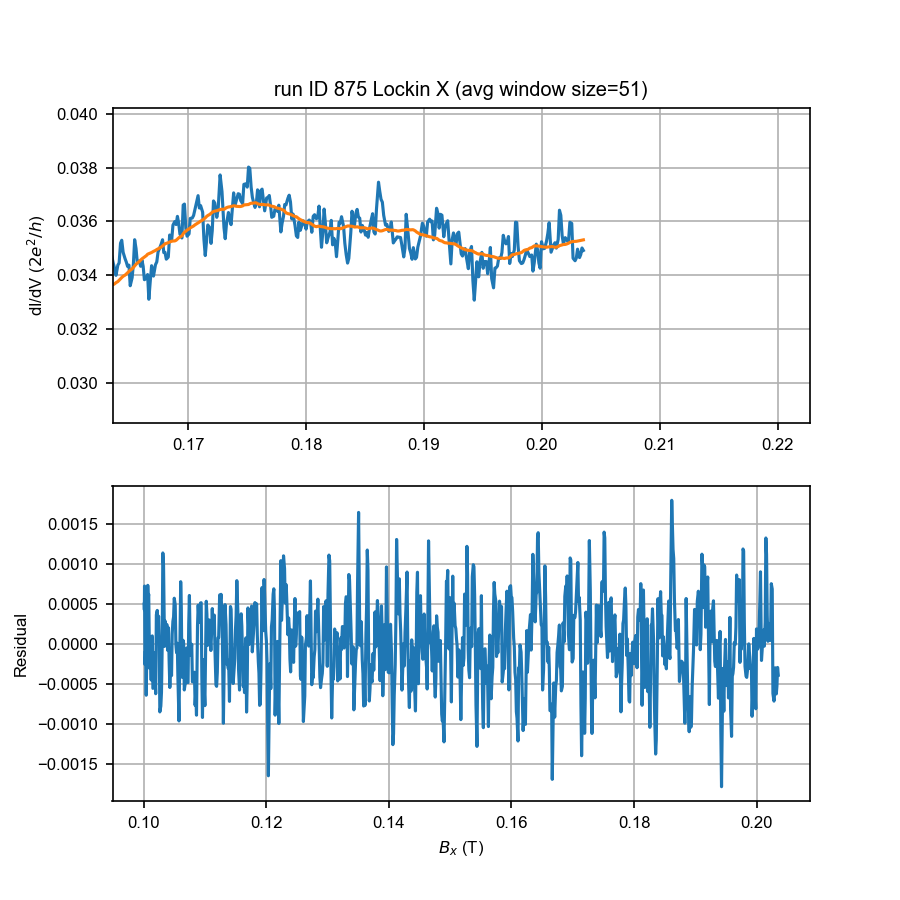

In [425]:
B_values = np.array(dat_AB.get_values('B_x'))[:,0]
B_min, B_max = min(B_values), max(B_values)
npoints = B_values.size
conductance_values = np.array(dat_AB.get_values('conductance'))[:,0]

avg_window_size = 51
conductance_background = smooth(conductance_values, avg_window_size, 1) # 31 points ~ 15mT, close to expected period
conductance_residual = conductance_values - conductance_background

plt.figure('fft background', figsize=(6,6))
plt.subplot(211)
plt.plot(B_values, conductance_values, B_values, conductance_background)
plt.grid(b=True)
plt.title('run ID ' + '{}'.format(dat_AB.run_id) + ' Lockin X (avg window size=' + str(avg_window_size) + ')')
plt.ylabel('dI/dV ($2e^2/h$)')
plt.subplot(212)
plt.plot(B_values, conductance_residual)
plt.ylabel('Residual')
plt.xlabel('$B_x$ (T)')
plt.grid(b=True)

<IPython.core.display.Javascript object>


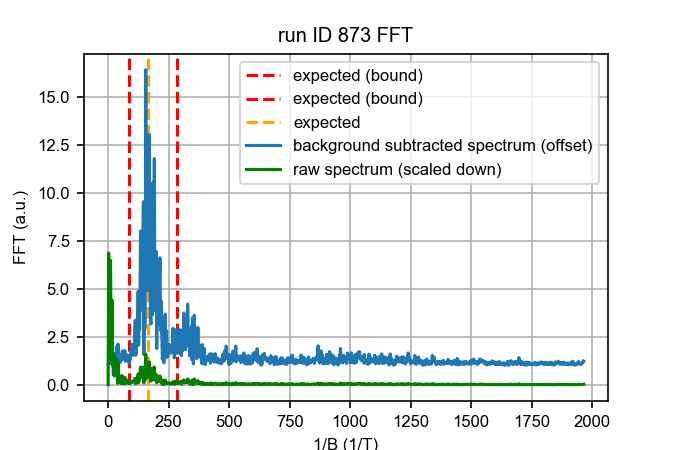

In [421]:
# FFT
n_cutoff = 1000

fft_ab = np.fft.fft(conductance_residual)
fft_non_avgd = np.fft.fft(conductance_values - conductance_values.mean())
B_inv = np.linspace(0, npoints/(B_max-B_min), npoints)

plt.figure('abfft')
plt.axvline(x=85.8, color='red', linestyle='dashed')
plt.axvline(x=283, color='red', linestyle='dashed')
plt.axvline(x=165, color='orange', linestyle='dashed')
plt.plot(B_inv[:n_cutoff], np.abs(fft_ab)[:n_cutoff]+1)
plt.plot(B_inv[:n_cutoff], 0.1*np.abs(fft_non_avgd)[:n_cutoff], color='green')
plt.xlabel('1/B (1/T)')
plt.ylabel('FFT (a.u.)')
plt.title('run ID ' + '{}'.format(dat_AB.run_id) + ' FFT')
plt.legend(['expected (bound)', 'expected (bound)', 'expected', 'background subtracted spectrum (offset)', 'raw spectrum (scaled down)'])
plt.grid(b=True)

### Averaging FFTs

<IPython.core.display.Javascript object>


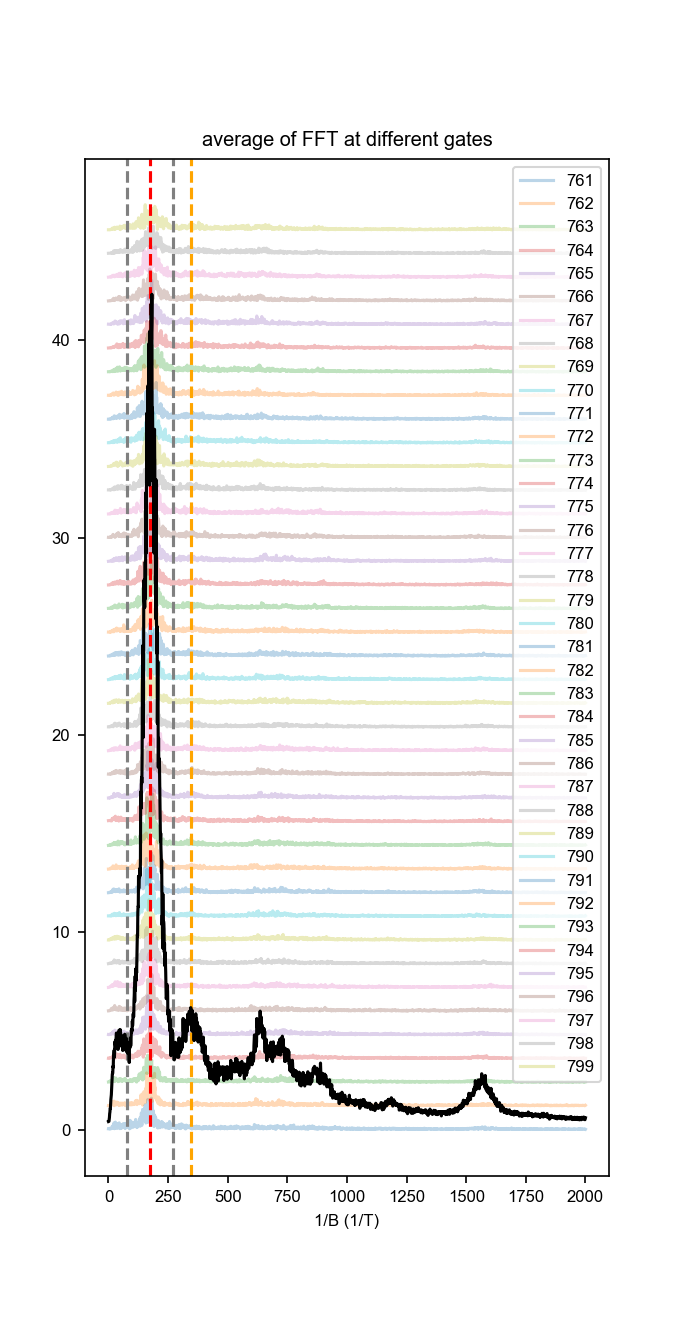

Text(0.5,0,'1/B (1/T)')

In [501]:
from scipy.signal import savgol_filter

data_id_list = range(761, 800)
# data_id_list = range(861,874)
# data_id_list = range(920,940)
number_points_list = [4000,4000,4000,4000]
n_cutoff = 2000

B_inv_unified = np.linspace(0,2000,2001)
fft_avg = np.zeros(B_inv_unified.shape)

plt.figure('all AB raw')

counter = 0
for data_id in data_id_list:
    dat_AB = load_by_id(data_id)
    B_values = np.array(dat_AB.get_values('B_x'))[:4000,0]
    B_min, B_max = min(B_values), max(B_values)
    npoints = B_values.size
    conductance_values = np.array(dat_AB.get_values('Lockin1_X'))[:4000,0]

    avg_window_size = 31
    conductance_background = smooth(conductance_values, avg_window_size, 1) # 31 points ~ 15mT, close to expected period
    conductance_residual = conductance_values - conductance_background
    
    fft_ab = np.abs(np.fft.fft(conductance_residual))
    B_inv = np.linspace(0, npoints/(B_max-B_min), npoints)
    
    B_inv_unified
    fft_ab_intp = np.interp(B_inv_unified, B_inv, fft_ab)
    fft_avg += fft_ab_intp
    
    plt.plot(B_inv_unified, 50*fft_ab_intp + 1.2*counter, alpha = 0.3)
    counter += 1

plt.legend(list(map(str, data_id_list)))
fft_avg /= len(data_id_list)
fft_scalar = 2000;
plt.axvline(x=78, color='grey', linestyle = 'dashed')
plt.axvline(x=271, color='grey', linestyle = 'dashed')
plt.axvline(x=174, color='red', linestyle = 'dashed')
plt.axvline(x=2*174, color='orange', linestyle = 'dashed')
plt.plot(B_inv_unified, fft_avg*fft_scalar, color = 'black')
# plt.plot(B_inv_unified, savgol_filter(fft_avg*fft_scalar, 31, 3), color = 'black')
plt.title('average of FFT at different gates')
plt.xlabel('1/B (1/T)')

## Temperature dependence

<IPython.core.display.Javascript object>


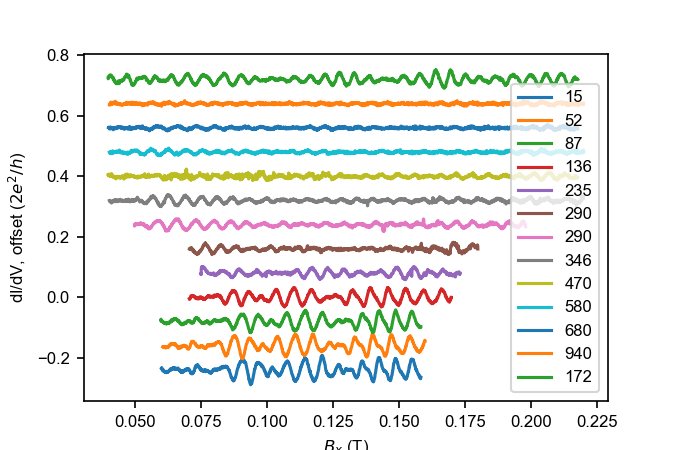

(1610,)
(1621,)
(1614,)
(1629,)
(1596,)
(1782,)
(2420,)
(2934,)
(2890,)
(2925,)
(2893,)
(2921,)
(2878,)


In [586]:
# plotting B curves
plt.figure('temp dep')
plt.xlabel('$B_x$ (T)')
plt.ylabel('dI/dV, offset ($2e^2/h$)')

T_list = [15,52,87,136,235,290,290,346,470,580,680,940, 172]
for i in range(1007, 1020):
    dat_AB = load_by_id(i)
    B_values = np.array(dat_AB.get_values('B_x'))[:,0]
    conductance_values = np.array(dat_AB.get_values('conductance'))[:,0]
    
    print(B_values.shape)
    
    avg_window_size = 101
    conductance_background = smooth(conductance_values, avg_window_size, 1) # 101 points ~ 5mT, close to expected period
    conductance_residual = conductance_values - conductance_background
    plt.plot(B_values, conductance_residual + 0.08*(i-1010))
    
plt.legend(T_list)

<IPython.core.display.Javascript object>


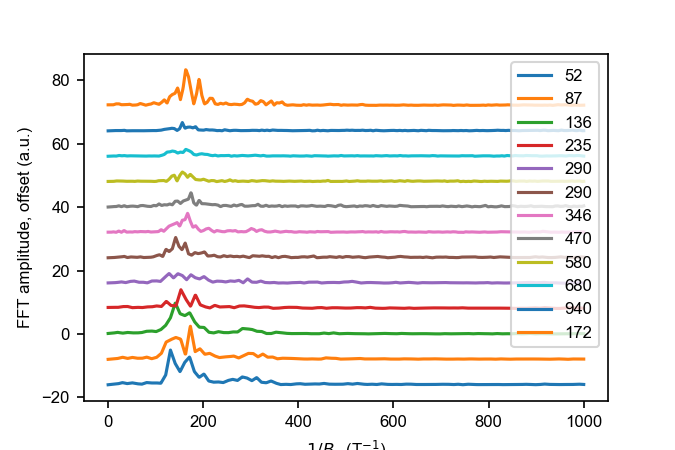

(1621,)
(1614,)
(1629,)
(1596,)
(1782,)
(2420,)
(2934,)
(2890,)
(2925,)
(2893,)
(2921,)
(2878,)


In [605]:
plt.figure('temp dep fft')
plt.xlabel('$1/B_x$ (T$^{-1}$)')
plt.ylabel('FFT amplitude, offset (a.u.)')
B_inv_unified = np.linspace(0,1000,1001)
amp_list = []

T_list = [52,87,136,235,290,290,346,470,580,680,940,172]
for i in range(1008, 1020):
    dat_AB = load_by_id(i)
    B_values = np.array(dat_AB.get_values('B_x'))[:,0]
    conductance_values = np.array(dat_AB.get_values('conductance'))[:,0]
    
    print(B_values.shape)
    
    avg_window_size = 101
    conductance_background = smooth(conductance_values, avg_window_size, 1) # 101 points ~ 5mT, close to expected period
    conductance_residual = conductance_values - conductance_background
    
    fft_ab = np.abs(np.fft.fft(conductance_residual))
    B_inv = np.linspace(0, B_values.size/(max(B_values)-min(B_values)), B_values.size)
    fft_ab_intp = np.interp(B_inv_unified, B_inv, fft_ab)
    
    plt.plot(B_inv_unified, fft_ab_intp + 8*(i-1010))
    amp_list.append(np.sum(fft_ab_intp[85:283]))
    
plt.legend(T_list)


<IPython.core.display.Javascript object>


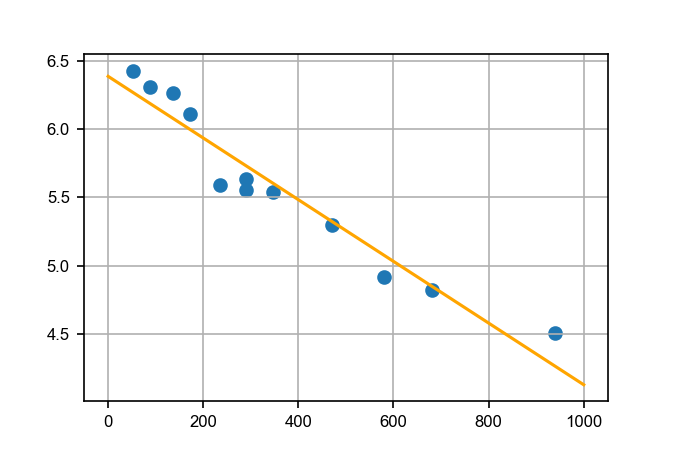

In [607]:
plt.figure('t vs amp')
plt.scatter(T_list, np.log(amp_list))
plt.grid(b=True)
[linfit_a, linfit_b] = np.polyfit(T_list, np.log(amp_list), deg=1)
x = np.arange(0,1100,100)
plt.plot(x, linfit_a * x + linfit_b, color='orange')

In [608]:
linfit_a, linfit_b

(-0.002263489147930759, 6.389031977320947)